In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_excel("tumor-data.xlsx")

In [3]:
data = data.drop(["Unnamed: 6", "Unnamed: 0", "Unnamed: 2"], axis=1)

In [4]:
labels = [value for column, value in data.iloc[0].items()]

In [5]:
data = data.set_axis(labels, axis=1)
data = data.drop(index=0)

In [6]:
null_data_coefficients = data.isna().sum() / len(data) * 100

In [7]:
data = data[data.columns[1:]].apply(
    lambda x: pd.to_numeric(x.replace('<', '').replace(',', '.'), errors='coerce')
)

In [8]:
data_encoded = pd.get_dummies(data, columns=["1-адренокортикальный рак, 2- аденома,0 -здоровые"], prefix="disease",
    prefix_sep="_")
data_encoded.rename(columns={'disease_0.0': "healthy",
                             'disease_1.0': "cancer",
                             'disease_2.0': "adenoma"}, inplace=True)

In [9]:
data_cleaned = data_encoded.dropna(how='all')

In [10]:
data_cleaned.corr()

,Гормональная активность 0-нет 1-да,"Пол: 0-жен, 1-муж","Максимальный размер, мм","Нативная плотность, НU",APW % КВ - коэф вымывания,Weiss,Ki-67,Кортизол слюны,Свободный кортизол мочи (ХЛА),Кортизол крови утро,...,16-OHdP2-3a/16-OHdP2-3b,11dP3,dP3-3b,5b-А2,21dP2,6P,ННА,healthy,cancer,adenoma
Гормональная активность 0-нет 1-да,1.000000,-0.107793,-0.225926,-0.122105,0.225797,-0.080209,0.107393,0.374329,0.388594,0.248587,...,0.235226,0.019512,0.315723,0.122368,-0.298835,0.072579,0.228619,-0.382740,0.035772,0.244104
"Пол: 0-жен, 1-муж",-0.107793,1.000000,0.148558,-0.017619,-0.017631,0.026824,0.130325,0.057538,0.013754,0.075264,...,-0.045288,-0.081835,-0.097431,0.107236,-0.220404,0.006738,-0.192047,0.110745,0.039507,-0.118717
"Максимальный размер, мм",-0.225926,0.148558,1.000000,0.381553,-0.154607,0.636790,0.517100,-0.052469,0.136067,0.151248,...,0.116735,0.156506,0.125373,0.504071,0.033668,0.141237,0.162948,NaN,0.632294,-0.632294
"Нативная плотность, НU",-0.122105,-0.017619,0.381553,1.000000,0.120740,0.452552,0.372753,0.180606,0.241422,0.122469,...,-0.179313,0.274364,0.279511,0.359748,0.028715,0.446444,0.031128,NaN,0.538831,-0.538831
APW % КВ - коэф вымывания,0.225797,-0.017631,-0.154607,0.120740,1.000000,-0.088364,0.191969,-0.095525,-0.109771,0.116562,...,-0.027555,0.074654,0.008557,-0.251771,-0.310809,-0.210671,-0.116137,NaN,-0.126842,0.126842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6P,0.072579,0.006738,0.141237,0.446444,-0.210671,0.473809,0.426799,0.009656,0.001668,-0.083163,...,-0.254566,-0.126777,0.515409,0.264434,-0.092170,1.000000,0.051551,NaN,0.070482,-0.070482
ННА,0.228619,-0.192047,0.162948,0.031128,-0.116137,0.075361,0.688747,-0.022765,0.166684,0.032522,...,0.560864,0.090903,0.050002,-0.173902,0.913002,0.051551,1.000000,-0.222167,0.120750,0.066387
healthy,-0.382740,0.110745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.476728,NaN,-0.267426,-0.143718,NaN,NaN,-0.222167,1.000000,-0.341521,-0.352493
cancer,0.035772,0.039507,0.632294,0.538831,-0.126842,0.820270,0.416550,0.089210,0.301109,0.171253,...,0.301367,0.173868,0.341497,0.410639,0.273152,0.070482,0.120750,-0.341521,1.000000,-0.718003


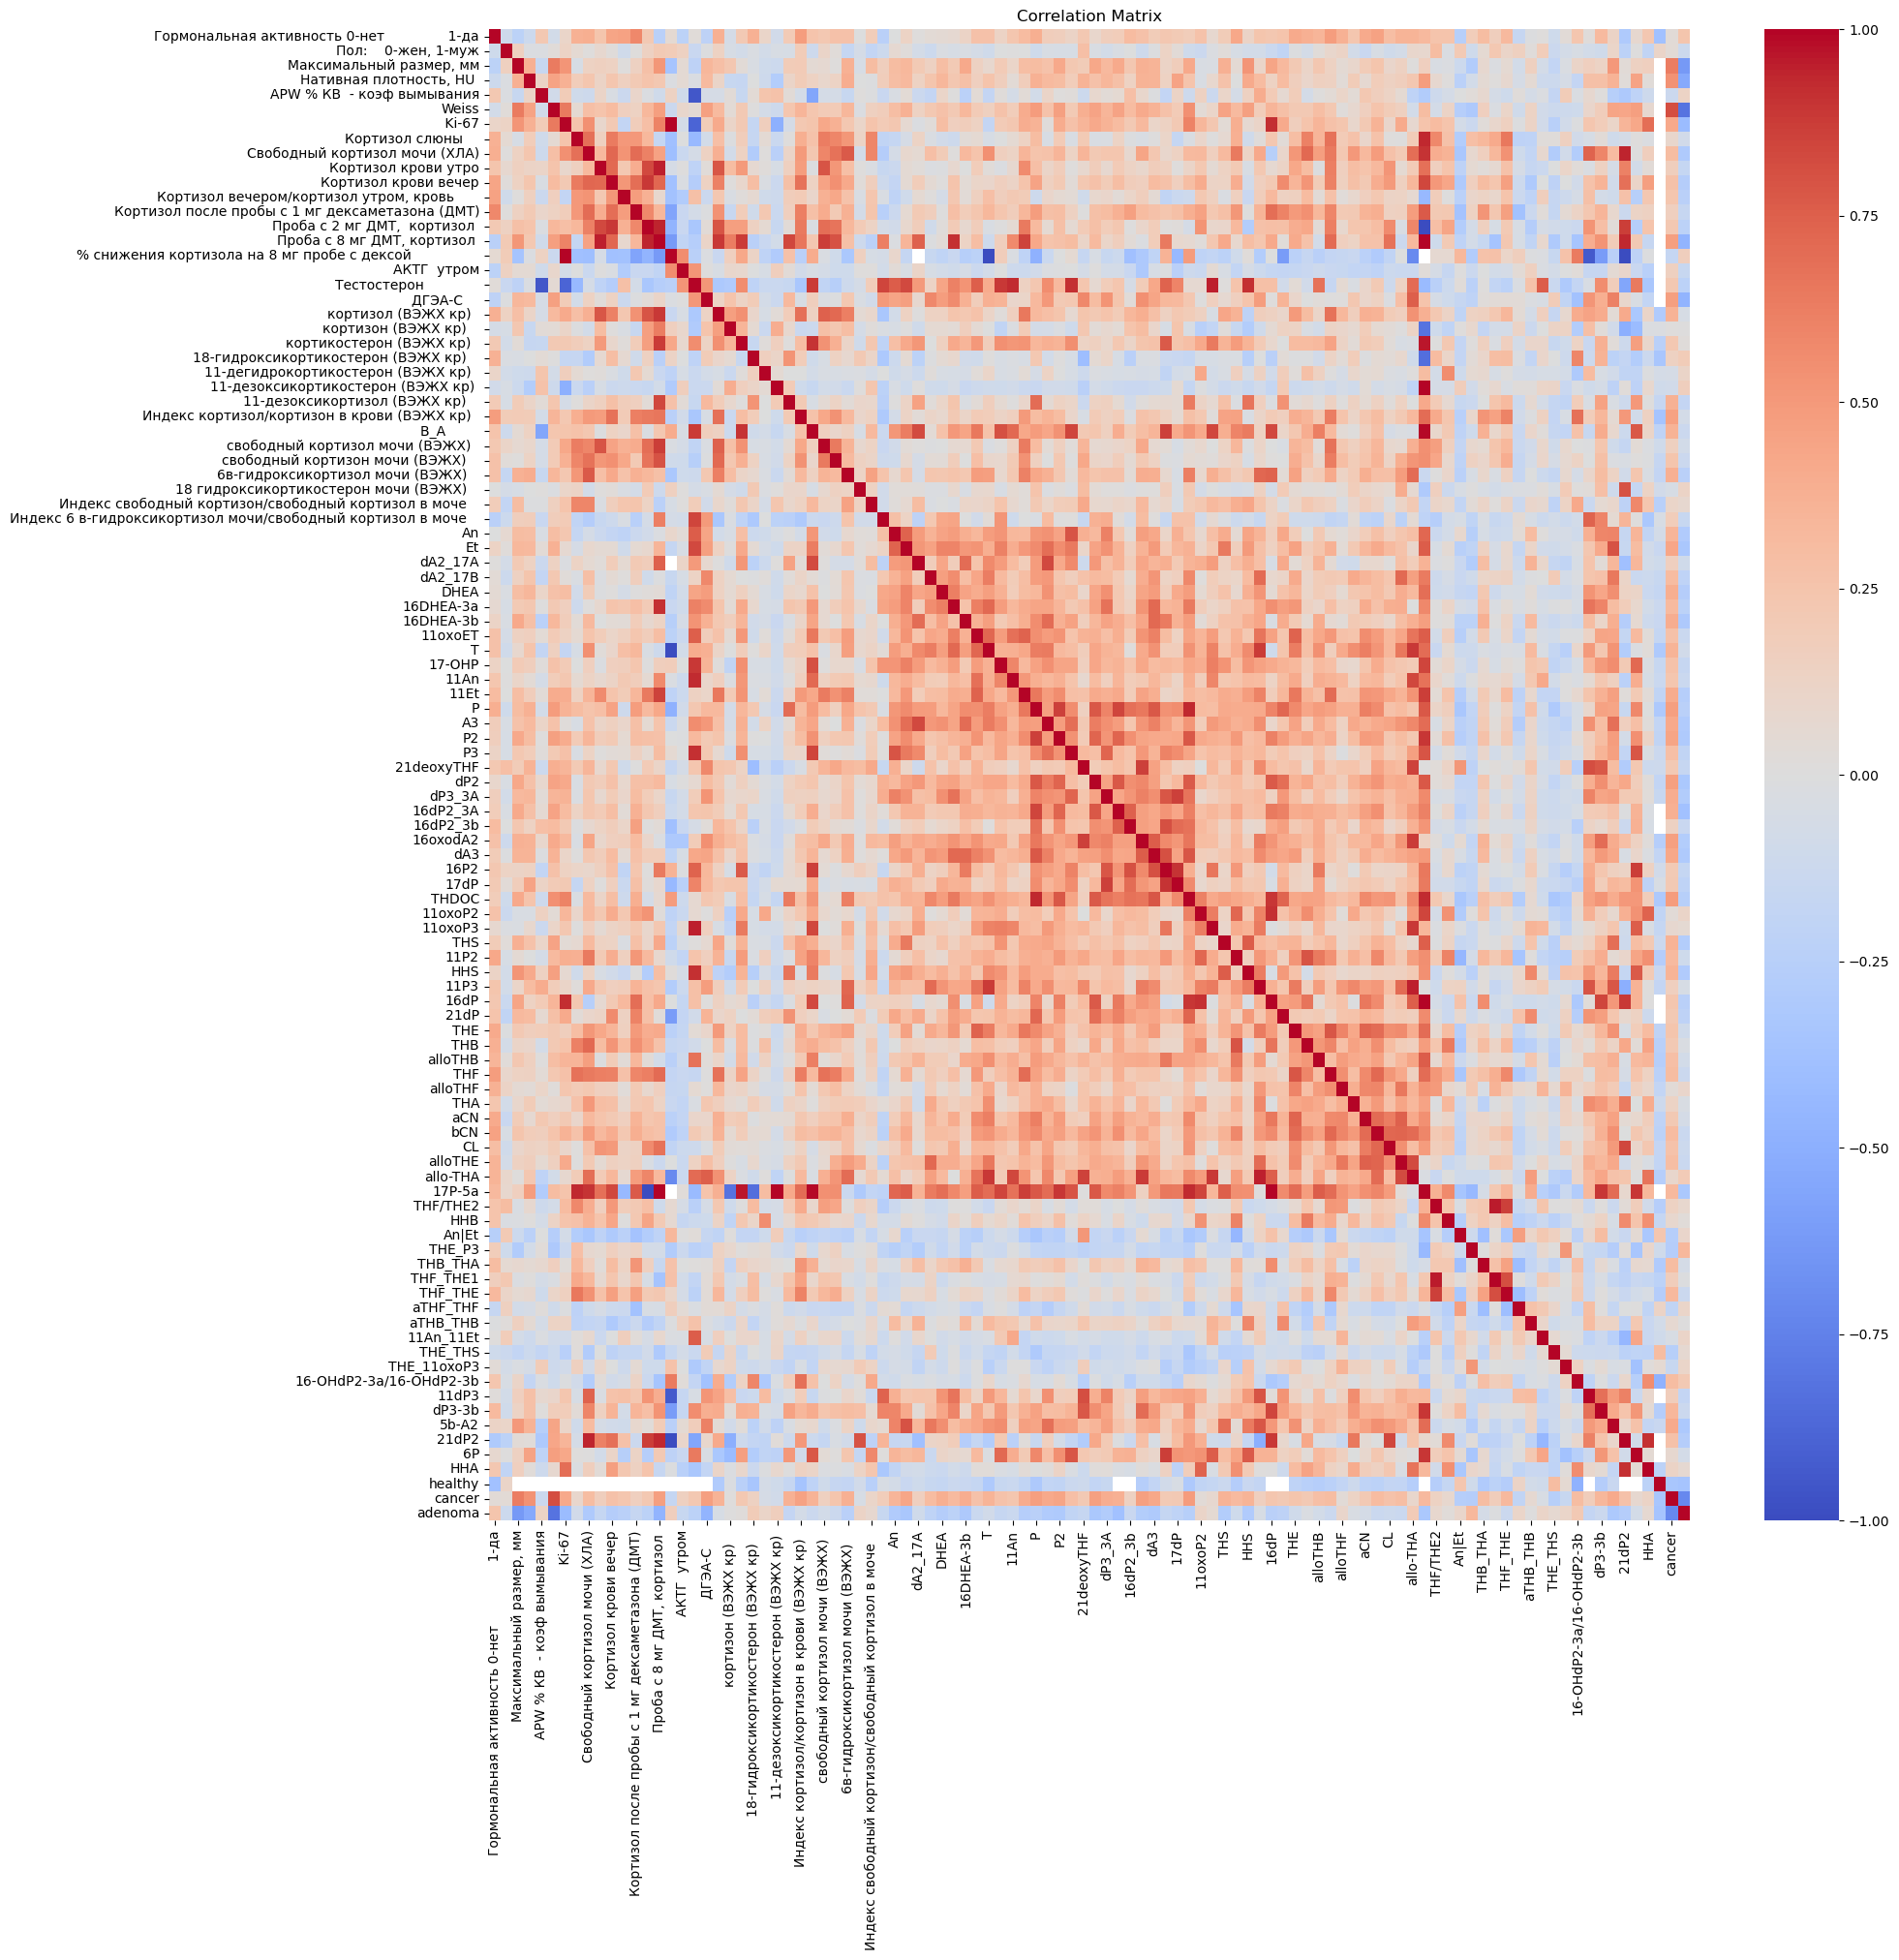

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data_cleaned.corr()

plt.figure(figsize=(20, 20))

sns.heatmap(correlation_matrix, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [12]:
#dropping useless near 0 correlation features

data_cleaned.drop(["Пол:    0-жен, 1-муж"], axis=1, inplace=True)

In [13]:
X = data_cleaned.drop(columns=["cancer", "adenoma", "healthy"])
y = np.argmax(data_cleaned[["cancer", "adenoma", "healthy"]], axis=1)

In [14]:
X["Гормональная активность 0-нет               1-да"] = X["Гормональная активность 0-нет               1-да"].astype(str)
X["Гормональная активность 0-нет               1-да"] = X["Гормональная активность 0-нет               1-да"].fillna("missing")

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           depth=6,
                           learning_rate=0.05,
                           loss_function="MultiClass",
                           custom_loss=["AUC", "Accuracy"],
                           cat_features = ["Гормональная активность 0-нет               1-да"],
                           verbose=10)

In [17]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0613215	test: 1.0688789	best: 1.0688789 (0)	total: 160ms	remaining: 15.8s
10:	learn: 0.8201843	test: 0.8620642	best: 0.8620642 (10)	total: 479ms	remaining: 3.88s
20:	learn: 0.6375928	test: 0.7035813	best: 0.7035813 (20)	total: 825ms	remaining: 3.1s
30:	learn: 0.5345953	test: 0.6136577	best: 0.6136577 (30)	total: 1.16s	remaining: 2.58s
40:	learn: 0.4421183	test: 0.5306869	best: 0.5306869 (40)	total: 1.5s	remaining: 2.15s
50:	learn: 0.3729722	test: 0.4664488	best: 0.4664488 (50)	total: 1.84s	remaining: 1.77s
60:	learn: 0.3234693	test: 0.4235874	best: 0.4235874 (60)	total: 2.17s	remaining: 1.39s
70:	learn: 0.2822985	test: 0.3919944	best: 0.3919944 (70)	total: 2.52s	remaining: 1.03s
80:	learn: 0.2490433	test: 0.3642023	best: 0.3642023 (80)	total: 2.86s	remaining: 671ms
90:	learn: 0.2223844	test: 0.3400276	best: 0.3400276 (90)	total: 3.22s	remaining: 318ms
99:	learn: 0.1979236	test: 0.3190244	best: 0.3190244 (99)	total: 3.53s	remaining: 0us

bestTest = 0.3190243781
bestIteration

In [18]:
y_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Получаем точность
print("Accuracy:", accuracy_score(y_test, y_pred))

# Подробный отчет о классификации
print(classification_report(y_test, y_pred))

Accuracy: 0.9322033898305084
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.92      0.92      0.92        26
           2       1.00      1.00      1.00         7

    accuracy                           0.93        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.93      0.93      0.93        59



In [20]:
feature_importances = model.get_feature_importance()
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
4,Weiss,22.936922
15,АКТГ утром,9.249276
8,Кортизол крови утро,6.920800
1,"Максимальный размер, мм",5.463212
53,16dP2_3b,4.252499
...,...,...
95,21dP2,0.020204
56,16P2,0.000000
47,P2,0.000000
14,% снижения кортизола на 8 мг пробе с дексой ...,0.000000


In [22]:
"""

Небольшие пояснения главных фичей

Weiss — это шкала, используемая для прогноза опухолей, особенно в контексте адренокортикальных карцином
(раков надпочечников)

АКТГ — это гормон, который вырабатывается в передней доле гипофиза. Он регулирует деятельность надпочечников, в частности, стимулирует выработку кортизола.

16-OHdP — это метаболит 16-гидроксипрогестерона (16-OH-прогестерона), который является производным прогестерона и может быть связан с функцией надпочечников.

APW % КВ  - коэф вымывания - скорость или степени вымывания контрастного вещества или радиофармпрепаратов из опухоли и окружающих тканей. Это может быть использовано для диагностики, оценки агрессивности опухоли, а также для мониторинга эффективности лечения.

"""

'\n\nНебольшие пояснения главных фичей\n\nWeiss — это шкала, используемая для прогноза опухолей, особенно в контексте адренокортикальных карцином\n(раков надпочечников)\n\nАКТГ — это гормон, который вырабатывается в передней доле гипофиза. Он регулирует деятельность надпочечников, в частности, стимулирует выработку кортизола.\n\n16-OHdP — это метаболит 16-гидроксипрогестерона (16-OH-прогестерона), который является производным прогестерона и может быть связан с функцией надпочечников.\n\nAPW % КВ  - коэф вымывания - скорость или степени вымывания контрастного вещества или радиофармпрепаратов из опухоли и окружающих тканей. Это может быть использовано для диагностики, оценки агрессивности опухоли, а также для мониторинга эффективности лечения.\n\n'